<a href="https://colab.research.google.com/github/willcoomans5/mlb_predictions/blob/main/mlb_game_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# import os, sys
# nb_path = '/content/notebooks'
# os.symlink('/content/drive/MyDrive/Colab Notebooks', nb_path)
# sys.path.insert(0,nb_path)

In [3]:
!pip3 install torch torchvision torchaudio pybaseball scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 11.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [4]:
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import *
import numpy as np
import pybaseball as pyb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from datetime import date
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split



pyb.cache.enable()
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)


In [5]:
path = '/content/drive/MyDrive/mlbpredictions/'

In [6]:
statcast_data = pyb.statcast(start_dt='2023-03-28', end_dt='2023-11-01')

This is a large query, it may take a moment to complete


100%|██████████| 219/219 [05:54<00:00,  1.62s/it]


In [6]:
print(statcast_data.shape)
statcast_data.to_csv(path + "statcast_2023.csv")

NameError: name 'statcast_data' is not defined

In [7]:
# Interesting Features:
# use release_spin_rate, spin_axis, vx0, vy0, vz0, pfx_x, pfx_z
# maybe release_extension, release_pos_x, release_pos_z

In [8]:
sc = pd.read_csv(path + "statcast_2023.csv")
data = sc.sample(200000, random_state=42)

In [9]:
features = ['release_spin_rate', 'release_speed', 'release_extension',
            'release_pos_x', 'release_pos_z', 'spin_axis', 'vx0', 'vy0',
            'vz0', 'pfx_x', 'pfx_z', 'p_throws', 'balls', 'strikes']

target = 'pitch_name'
data = data[features + [target]]
X = data.drop(columns=["pitch_name"])
y = data["pitch_name"]

train_valid, test = train_test_split(data, test_size=0.2, random_state=42)
train, valid = train_test_split(train_valid, test_size=0.2, random_state=42)
print(train.shape)
print(valid.shape)
print(test.shape)

(128000, 15)
(32000, 15)
(40000, 15)


In [10]:
print(train["pitch_name"].value_counts())
print("\n")
print(train.isnull().sum())

pitch_name
4-Seam Fastball    41336
Slider             21513
Sinker             19670
Changeup           13786
Cutter              9954
Curveball           8794
Sweeper             6500
Split-Finger        2873
Knuckle Curve       2537
Slurve               408
Other                213
Forkball             142
Eephus                85
Knuckleball           37
Screwball             20
Slow Curve            14
Pitch Out             11
Name: count, dtype: int64


release_spin_rate    838
release_speed        108
release_extension    301
release_pos_x        108
release_pos_z        108
spin_axis            838
vx0                  108
vy0                  108
vz0                  108
pfx_x                108
pfx_z                108
p_throws               0
balls                  0
strikes                0
pitch_name           107
dtype: int64


Only 103 out of our 128000 training samples have missing dependent values. As shown above, these data points appear to be insignificant, as most of the remaining features have missing values as well. Consequently, removing these 103 rows is justified.

Below, we will handle the rest of the missing values appropriately. We will also one hot encode our "p_throws" column.



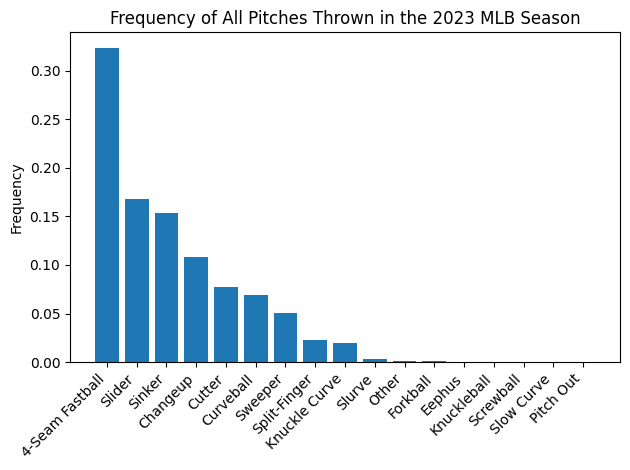

In [11]:
train = train[~train["pitch_name"].isnull()]

freq = train["pitch_name"].value_counts() / len(train)
plt.bar(x=freq.index, height=freq)
plt.xticks(rotation=45, ha='right')
plt.title("Frequency of All Pitches Thrown in the 2023 MLB Season")
plt.ylabel("Frequency")
plt.tight_layout()

In [12]:
# Map right handed pitchers to the value 1 and left handed pitchers to the value 0

def p_throws_ohe(data):
  mapping_dict = {"L": 0, "R": 1}

  # Check for existing numerical values and map only non-numerical values
  if type(data['p_throws'].iloc[0]) == str:
    data['p_throws'] = train['p_throws'].map(mapping_dict)
  return data


# Display the result
train = p_throws_ohe(train)
train.head(100)

,release_spin_rate,release_speed,release_extension,release_pos_x,release_pos_z,spin_axis,vx0,vy0,vz0,pfx_x,pfx_z,p_throws,balls,strikes,pitch_name
213162,2487.0,96.0,6.7,-2.48,5.64,219.0,11.699403,-139.236553,-4.681065,-1.36,0.59,1,0,0,Sinker
345135,2209.0,98.8,6.5,-1.62,5.84,206.0,4.926560,-143.693296,-5.942054,-0.57,1.47,1,0,0,4-Seam Fastball
433431,2653.0,83.6,7.8,-2.14,5.34,274.0,6.284207,-121.652556,-2.142796,-1.43,0.05,1,0,0,Changeup
624595,2414.0,96.9,6.4,-2.75,5.50,208.0,9.834019,-140.680400,-7.153856,-0.60,1.63,1,1,1,4-Seam Fastball
187119,2029.0,94.4,5.7,-2.02,5.79,219.0,8.124374,-137.185937,-5.212608,-0.77,1.04,1,1,1,4-Seam Fastball
435317,2164.0,91.0,6.2,-1.54,6.32,167.0,2.301404,-132.461860,0.270827,0.46,0.25,1,2,2,Cutter
398724,1868.0,85.8,6.2,2.10,4.84,82.0,-5.603282,-124.857862,1.803321,1.47,0.02,0,3,1,Changeup
529520,2624.0,87.9,6.5,-1.45,6.09,177.0,-0.235032,-128.104897,-2.369848,0.64,0.79,1,1,1,Cutter
174200,619.0,83.0,6.1,-0.63,6.23,246.0,0.221463,-120.858640,-2.782101,-0.96,0.27,1,3,2,Split-Finger
342253,2063.0,94.4,5.9,0.95,6.67,146.0,-3.152457,-137.511430,-4.046967,0.78,1.36,0,0,2,4-Seam Fastball


Let's visualize some of the distributions of our features

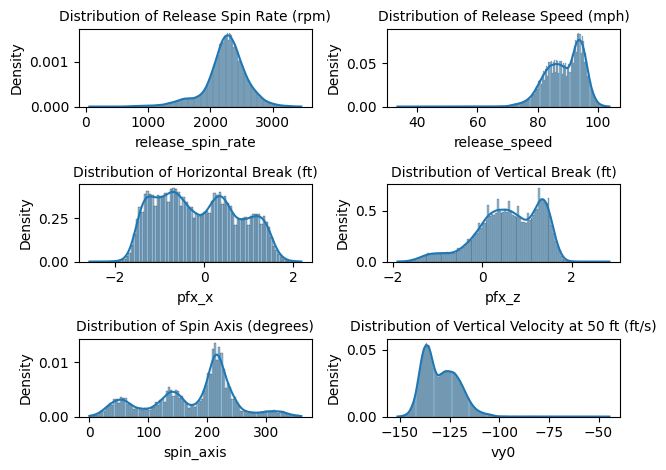

In [13]:
fig, ax = plt.subplots(3, 2)

sns.histplot(data=train, x="release_spin_rate", stat='density', kde=True, ax=ax[0, 0])
ax[0, 0].set_title("Distribution of Release Spin Rate (rpm)", fontsize=10)

sns.histplot(data=train, x="release_speed", stat='density', kde=True, ax=ax[0, 1])
ax[0, 1].set_title("Distribution of Release Speed (mph)", fontsize=10)

sns.histplot(data=train, x="pfx_x", stat='density', kde=True, ax=ax[1, 0])
ax[1, 0].set_title("Distribution of Horizontal Break (ft)", fontsize=10)

sns.histplot(data=train, x="pfx_z", stat='density', kde=True, ax=ax[1, 1])
ax[1, 1].set_title("Distribution of Vertical Break (ft)", fontsize=10)

sns.histplot(data=train, x="spin_axis", stat='density', kde=True, ax=ax[2, 0])
ax[2, 0].set_title("Distribution of Spin Axis (degrees)", fontsize=10)

sns.histplot(data=train, x="vy0", stat='density', kde=True, ax=ax[2, 1])
ax[2, 1].set_title("Distribution of Vertical Velocity at 50 ft (ft/s)", fontsize=10)


plt.tight_layout()
plt.show()

In [14]:
def fill_vals(data):
  data['release_spin_rate'] = data['release_spin_rate'].fillna(data['release_spin_rate'].mean())
  data['release_speed'] = data['release_speed'].fillna(data['release_speed'].mean())
  data['release_extension'] = data['release_extension'].fillna(data['release_extension'].mean())
  data['release_extension'] = data['release_extension'].fillna(data['release_extension'].mean())
  data['release_pos_x'] = data['release_pos_x'].fillna(data['release_pos_x'].mode()[0])
  data['release_pos_z'] = data['release_pos_z'].fillna(data['release_pos_z'].mean())
  data['spin_axis'] = data['spin_axis'].fillna(data['spin_axis'].mode()[0])
  data['pfx_x'] = data['pfx_x'].fillna(data['pfx_x'].mean())
  data['pfx_z'] = data['pfx_z'].fillna(data['pfx_z'].mean())
  data['vx0'] = data['vx0'].fillna(data['vx0'].mean())
  data['vy0'] = data['vy0'].fillna(data['vy0'].mean())
  data['vz0'] = data['vz0'].fillna(data['vz0'].mean())
  return data

train = fill_vals(train)
print(train.isnull().sum())

release_spin_rate    0
release_speed        0
release_extension    0
release_pos_x        0
release_pos_z        0
spin_axis            0
vx0                  0
vy0                  0
vz0                  0
pfx_x                0
pfx_z                0
p_throws             0
balls                0
strikes              0
pitch_name           0
dtype: int64


In [15]:
def label_encode(data):
  le = LabelEncoder()
  le.fit(data['pitch_name'])
  data['pitch_name'] = le.transform(data['pitch_name'])
  return data, le

train, le = label_encode(train)
for idx, label in enumerate(le.classes_):
  print(f"label: {label}, encoding: {idx}")

label: 4-Seam Fastball, encoding: 0
label: Changeup, encoding: 1
label: Curveball, encoding: 2
label: Cutter, encoding: 3
label: Eephus, encoding: 4
label: Forkball, encoding: 5
label: Knuckle Curve, encoding: 6
label: Knuckleball, encoding: 7
label: Other, encoding: 8
label: Pitch Out, encoding: 9
label: Screwball, encoding: 10
label: Sinker, encoding: 11
label: Slider, encoding: 12
label: Slow Curve, encoding: 13
label: Slurve, encoding: 14
label: Split-Finger, encoding: 15
label: Sweeper, encoding: 16


In [16]:
def normalize(data):
  cols = ['release_spin_rate', 'release_speed', 'release_extension',
            'release_pos_x', 'release_pos_z', 'spin_axis', 'vx0', 'vy0',
            'vz0', 'pfx_x', 'pfx_z', 'balls', 'strikes']

  df = data.copy()[cols]
  data.loc[:, cols] = (df - df.min()) / (df.max() - df.min())
  return data

train = normalize(train)
train

,release_spin_rate,release_speed,release_extension,release_pos_x,release_pos_z,spin_axis,vx0,vy0,vz0,pfx_x,pfx_z,p_throws,balls,strikes,pitch_name
213162,0.713194,0.887943,0.672727,0.238397,0.723565,0.608333,0.753687,0.112235,0.403821,0.256303,0.524313,1,0.00,0.0,11
345135,0.631502,0.927660,0.636364,0.329114,0.753776,0.572222,0.583196,0.070464,0.365536,0.422269,0.710359,1,0.00,0.0,0
433431,0.761975,0.712057,0.872727,0.274262,0.678248,0.761111,0.617371,0.277042,0.480886,0.241597,0.410148,1,0.00,0.0,1
624595,0.691743,0.900709,0.618182,0.209916,0.702417,0.577778,0.706730,0.098702,0.328744,0.415966,0.744186,1,0.25,0.5,0
187119,0.578607,0.865248,0.490909,0.286920,0.746224,0.608333,0.663693,0.131454,0.387683,0.380252,0.619450,1,0.25,0.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163317,0.512783,0.706383,0.600000,0.270042,0.681269,0.336111,0.506928,0.281826,0.524083,0.831933,0.446089,1,0.25,1.0,16
175735,0.601822,0.771631,0.745455,0.338608,0.637462,0.425000,0.566381,0.218500,0.436387,0.640756,0.460888,1,0.00,0.5,12
512359,0.593300,0.817021,0.581818,0.381857,0.861027,0.580556,0.553218,0.176060,0.338553,0.447479,0.661734,1,0.50,0.5,0
244001,0.820746,0.787234,0.581818,0.459916,0.774924,0.302778,0.479919,0.202629,0.455146,0.676471,0.363636,1,0.25,0.0,12


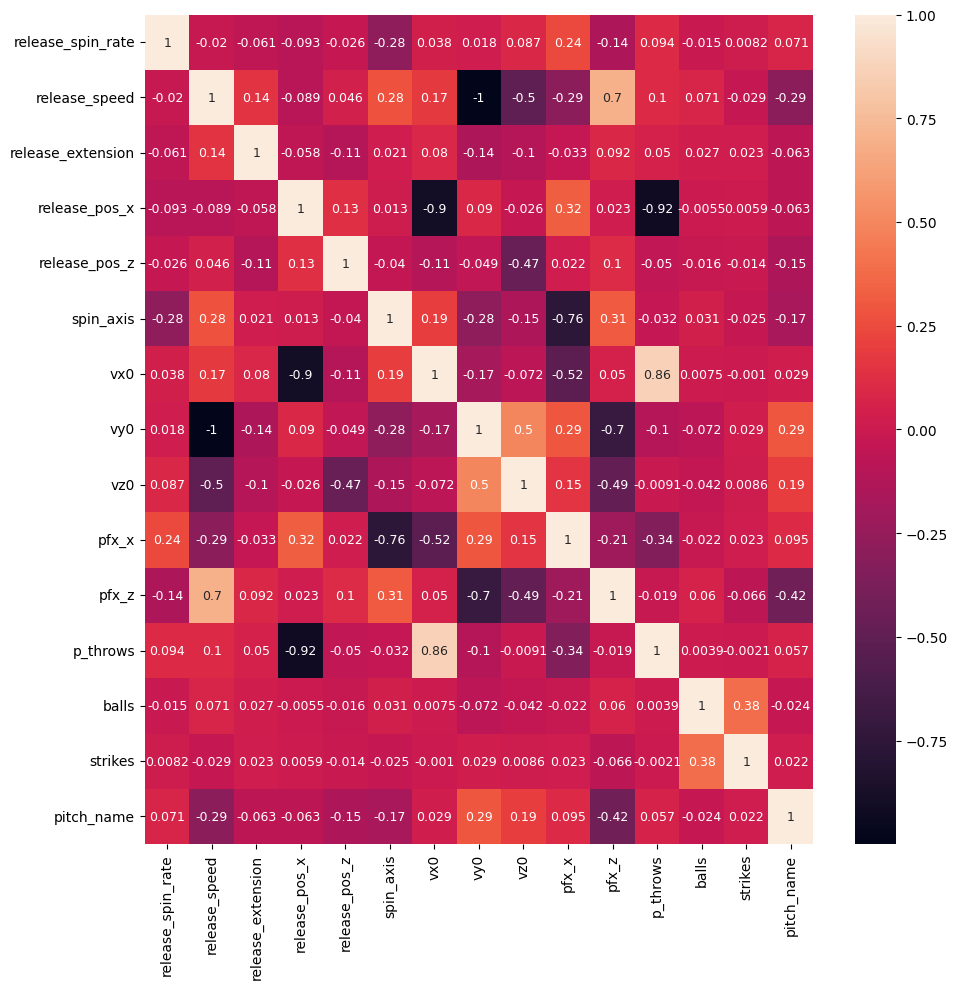

In [17]:
corr_data = train[features + [target]].corr(method='pearson')
plt.figure(figsize=(10, 10))
sns.heatmap(data=corr_data, annot=True, annot_kws={"size": 9})
plt.tight_layout()

In [18]:
def pipeline(data):
  df = data.copy()
  df = df.pipe(p_throws_ohe)
  df = df.pipe(fill_vals)
  df = label_encode(df)[0]
  df = normalize(df)
  y = torch.tensor(df["pitch_name"].values)
  X = torch.tensor(df.drop(columns=["pitch_name"]).values)
  return X, y

X_train, Y_train = pipeline(train)
X_valid, Y_valid = pipeline(valid)
X_test, Y_test = pipeline(test)

In [19]:
class CustomMLBDataSet(Dataset):
  def __init__(self, features, targets):
    self.features = features
    self.targets = targets

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    sample = self.features[idx], self.targets[idx]
    return sample

train_dataset = CustomMLBDataSet(X_train, Y_train)
valid_dataset = CustomMLBDataSet(X_valid, Y_valid)
test_dataset = CustomMLBDataSet(X_test, Y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [20]:
train_features, train_labels = next(iter(train_dataloader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')

Feature batch shape: torch.Size([16, 14])
Labels batch shape: torch.Size([16])


In [34]:
class SoftmaxRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(14, 16, bias=True)

  def forward(self, x):
    logits = self.linear(x)
    return logits

In [35]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'GPU device name: {torch.cuda.get_device_name(device)}')
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

model = SoftmaxRegression().to(device)
print(model)

GPU device name: Tesla T4
SoftmaxRegression(
  (linear): Linear(in_features=14, out_features=16, bias=True)
)


In [1]:
ex_data = torch.rand(2, 14, device=device)
logits = model(ex_data)
print(logits)
print(nn.Softmax(dim=1)(logits))
print(nn.Softmax(dim=0)(logits))


NameError: name 'torch' is not defined

In [23]:


import torch.nn.functional as F

# Sample logits (batch size = 2, number of classes = 3)
logits = torch.tensor([[1.0, 2.0, 3.0],
                       [1.0, 2.0, 3.0]])

# Sample target labels
targets = torch.tensor([2, 0])

# Create the loss function
criterion = nn.CrossEntropyLoss()

# Compute the loss
sum_loss = F.cross_entropy(logits, targets, reduction='sum')
avg_loss = F.cross_entropy(logits, targets, reduction='mean')
indiv_loss = F.cross_entropy(logits, targets, reduction='none')

print(sum_loss)
print(avg_loss)
print(indiv_loss)

tensor(2.8152)
tensor(1.4076)
tensor([0.4076, 2.4076])
